# Testing out different methods of normalizing the cholera cases
Using the WorldPop data from HDX: https://data.humdata.org/dataset/worldpop-population-counts-2015-2030-moz



In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [27]:
# Data and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from pathlib import Path
import os
import re
import rasterio
import geopandas as gpd
import rasterstats as rs
from fuzzywuzzy import process
from unidecode import unidecode
from src.constants import *

# Display settings
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.0f}".format
sns.set(style="whitegrid")

In [3]:
# load admin boundaries
adm2_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)
gdf_adm2 = gpd.read_file(adm2_path)

In [4]:
district_df = pd.read_csv(
    Path(os.getenv("AA_DATA_DIR"))
    / "private"
    / "processed"
    / "moz"
    / "cholera"
    / "cholera_data_cleaned.csv"
)
# only keep those with week values
district_df = district_df[district_df["week"].notna()]

In [5]:
# using the 2025 file
# worldpop_data_url = "https://data.worldpop.org/GIS/Population/Global_2015_2030/R2024B/2025/MOZ/v1/100m/constrained/moz_pop_2025_CN_100m_R2024B_v1.tif"
worldpop_data_url = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "worldpop"
    / "moz_pop_2025_CN_100m_R2024B_v1.tif"
)
# read in the file
worldpop_file = rasterio.open(worldpop_data_url)
worldpop_data = worldpop_file.read(1)
worldpop_data_masked = np.ma.masked_equal(worldpop_data, -99999)
mean_value = np.mean(worldpop_data_masked)
min_value = np.min(worldpop_data_masked)
max_value = np.max(worldpop_data_masked)

print(f"Min value: {min_value}")
print(f"Max value: {max_value}")
print(f"Mean: {mean_value}")

Min value: 0.0
Max value: 211.85263061523438
Mean: 2.2590607357433483


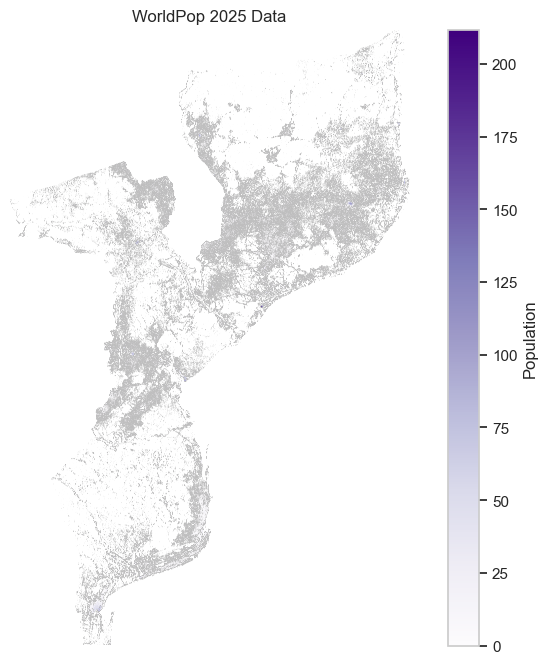

In [6]:
plt.figure(figsize=(10, 8))
plt.imshow(worldpop_data_masked, cmap="Purples")
plt.colorbar(label="Population")
plt.title("WorldPop 2025 Data")
plt.axis("off")
plt.show()

In [7]:
# aggregate the data to the district level
worldpop_data_agg = rs.zonal_stats(
    vectors=gdf_adm2,
    raster=worldpop_data_masked,
    stats=["sum"],
    nodata=-99999,
    affine=worldpop_file.transform,
)

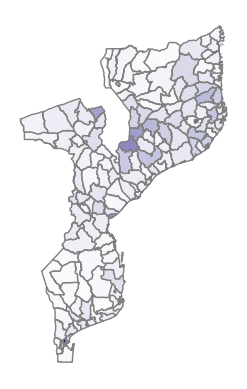

In [10]:
agg_df = pd.json_normalize(worldpop_data_agg)
gdf_adm2["sum_population"] = agg_df["sum"]
gdf_adm2.plot(
    column="sum_population",
    legend=False,
    cmap="Purples",
    edgecolor="grey",
)
plt.axis("off")
plt.show()

In [64]:
# it seems the admin bounds districts are not matching the cholera data ones
# trying some fuzzy matching to see if we can get a match
def normalize(text):
    return unidecode(str(text).lower().strip())


# add the population data to the gdf
pop_df = gdf_adm2[["ADM2_PT", "ADM1_PT", "sum_population"]]
district_df.loc[:, "district_norm"] = district_df["district"].apply(normalize)
pop_df["ADM2_PT_norm"] = pop_df["ADM2_PT"].apply(normalize)
mapping = {}
for name in district_df["district_norm"]:
    result = process.extractOne(name, pop_df["ADM2_PT_norm"])
    if result:
        match, score = result[0], result[1]
    if score >= 80:  # Set a threshold as needed
        match_row = pop_df[pop_df["ADM2_PT_norm"] == match].iloc[0]
        mapping[name] = match_row["ADM2_PT"]
district_df["matched_name"] = district_df["district_norm"].map(mapping)
district_df["date"] = pd.to_datetime(
    district_df["year"].astype(str)
    + district_df["week"].astype(int).astype(str).str.zfill(2)
    + "1",
    format="%G%V%u",
)
# Now, normalise the cholera data by population
district_pop_df = district_df.merge(
    pop_df, left_on="matched_name", right_on="ADM2_PT", how="left"
)

C:\Users\pauni\AppData\Local\Temp\ipykernel_19860\1762464823.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_df["ADM2_PT_norm"] = pop_df["ADM2_PT"].apply(normalize)


In [65]:
# check if merging is done well
# it should be empty if all the names are matched
district_pop_df[district_pop_df["ADM2_PT"].isna()][
    [
        "province",
        "district",
        "matched_name",
    ]
].drop_duplicates()

,province,district,matched_name


In [66]:
district_pop_df

,province,district,year,week,cases,district_norm,matched_name,date,ADM2_PT,ADM1_PT,sum_population,ADM2_PT_norm
0,Nampula,Angoche,2018,1,62,angoche,Angoche,2018-01-01,Angoche,Nampula,"434,710",angoche
1,Nampula,Angoche,2018,2,74,angoche,Angoche,2018-01-08,Angoche,Nampula,"434,710",angoche
2,Nampula,Angoche,2018,3,69,angoche,Angoche,2018-01-15,Angoche,Nampula,"434,710",angoche
3,Nampula,Angoche,2018,4,67,angoche,Angoche,2018-01-22,Angoche,Nampula,"434,710",angoche
4,Nampula,Angoche,2018,5,135,angoche,Angoche,2018-01-29,Angoche,Nampula,"434,710",angoche
...,...,...,...,...,...,...,...,...,...,...,...,...
14087,Zambezia,Quelim,2024,48,371,quelim,Cidade De Quelimane,2024-11-25,Cidade De Quelimane,Zambezia,"542,122",cidade de quelimane
14088,Zambezia,Quelim,2024,49,311,quelim,Cidade De Quelimane,2024-12-02,Cidade De Quelimane,Zambezia,"542,122",cidade de quelimane
14089,Zambezia,Quelim,2024,50,373,quelim,Cidade De Quelimane,2024-12-09,Cidade De Quelimane,Zambezia,"542,122",cidade de quelimane
14090,Zambezia,Quelim,2024,51,317,quelim,Cidade De Quelimane,2024-12-16,Cidade De Quelimane,Zambezia,"542,122",cidade de quelimane


In [67]:
# now, normalise the cholera data by population
district_pop_df["cases_per_100k"] = (
    district_pop_df["cases"] / district_pop_df["sum_population"]
) * 100000
district_pop_df["cases_per_100k"].describe()

count   13,488
mean        23
std         27
min          0
25%          5
50%         14
75%         32
max        774
Name: cases_per_100k, dtype: float64

In [68]:
# check the distribution of the cases per 100k
# look at 99th percentile to set a trigger for each province
# Calculate percentiles per province
percentiles = (
    district_pop_df.groupby("province")["cases_per_100k"]
    .quantile([0.99])
    .unstack()
)

# Merge percentiles back into the main df
district_df_with_percentiles = district_pop_df.merge(
    percentiles.rename(columns={0.99: "p99"}),
    left_on="province",
    right_index=True,
    how="left",
)
# Check if cases cross the thresholds
district_df_with_percentiles["above_99th"] = (
    district_df_with_percentiles["cases_per_100k"]
    > district_df_with_percentiles["p99"]
)
district_df_with_percentiles = district_df_with_percentiles.sort_values(
    ["district", "year", "week"]
)
# Create the new column: True only if this week and the previous two weeks are above the 99th percentile
district_df_with_percentiles["three_consec_above_99th"] = (
    district_df_with_percentiles["above_99th"]
    & district_df_with_percentiles.groupby("district")["above_99th"].shift(1)
    & district_df_with_percentiles.groupby("district")["above_99th"].shift(2)
)
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_above_99th"]
][["year", "week"]].drop_duplicates().sort_values(["year", "week"])
# the number of districts by year and by province when the threshold was crossed
all_years = district_df_with_percentiles["year"].unique()
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_above_99th"]
].groupby(["province", "year"])["district"].nunique().unstack(
    fill_value=0
).reindex(
    columns=sorted(all_years), fill_value=0
)

year,2018,2019,2020,2021,2022,2023,2024
province,,,,,,,
Nampula,0,0,1,2,3,0,0
Zambezia,0,0,1,1,0,1,1


In [69]:
# Filter if you want only the crossings
crossed_99th = district_df_with_percentiles[
    district_df_with_percentiles["three_consec_above_99th"]
]

district_trigger_99th = (
    crossed_99th.groupby(["province", "district", "year"])["week"]
    .count()
    .reset_index(name="week_count")
)
district_trigger_99th

,province,district,year,week_count
0,Nampula,Ilha de Moçambique,2020,5
1,Nampula,Ilha de Moçambique,2021,6
2,Nampula,Ilha de Moçambique,2022,6
3,Nampula,Lalaua,2022,2
4,Nampula,Nacala-Porto,2021,7
5,Nampula,Nacala-Porto,2022,1
6,Zambezia,Maganja,2020,1
7,Zambezia,Maganja,2021,3
8,Zambezia,Maganja,2024,7
9,Zambezia,Nicoadal,2023,1


In [70]:
district_df_with_percentiles[
    district_df_with_percentiles["district"].isin(
        district_trigger_99th["district"].unique()
    )
]

,province,district,year,week,cases,district_norm,matched_name,date,ADM2_PT,ADM1_PT,sum_population,ADM2_PT_norm,cases_per_100k,p99,above_99th,three_consec_above_99th
728,Nampula,Ilha de Moçambique,2018,1,73,ilha de mocambique,Ilha De Moçambique,2018-01-01,Ilha De Moçambique,Nampula,"80,999",ilha de mocambique,90,88,True,False
729,Nampula,Ilha de Moçambique,2018,2,57,ilha de mocambique,Ilha De Moçambique,2018-01-08,Ilha De Moçambique,Nampula,"80,999",ilha de mocambique,70,88,False,False
730,Nampula,Ilha de Moçambique,2018,3,84,ilha de mocambique,Ilha De Moçambique,2018-01-15,Ilha De Moçambique,Nampula,"80,999",ilha de mocambique,104,88,True,False
731,Nampula,Ilha de Moçambique,2018,4,48,ilha de mocambique,Ilha De Moçambique,2018-01-22,Ilha De Moçambique,Nampula,"80,999",ilha de mocambique,59,88,False,False
732,Nampula,Ilha de Moçambique,2018,5,74,ilha de mocambique,Ilha De Moçambique,2018-01-29,Ilha De Moçambique,Nampula,"80,999",ilha de mocambique,91,88,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13567,Zambezia,Nicoadal,2024,48,31,nicoadal,Nicoadala,2024-11-25,Nicoadala,Zambezia,"61,220",nicoadala,51,134,False,False
13568,Zambezia,Nicoadal,2024,49,26,nicoadal,Nicoadala,2024-12-02,Nicoadala,Zambezia,"61,220",nicoadala,42,134,False,False
13569,Zambezia,Nicoadal,2024,50,29,nicoadal,Nicoadala,2024-12-09,Nicoadala,Zambezia,"61,220",nicoadala,47,134,False,False
13570,Zambezia,Nicoadal,2024,51,27,nicoadal,Nicoadala,2024-12-16,Nicoadala,Zambezia,"61,220",nicoadala,44,134,False,False


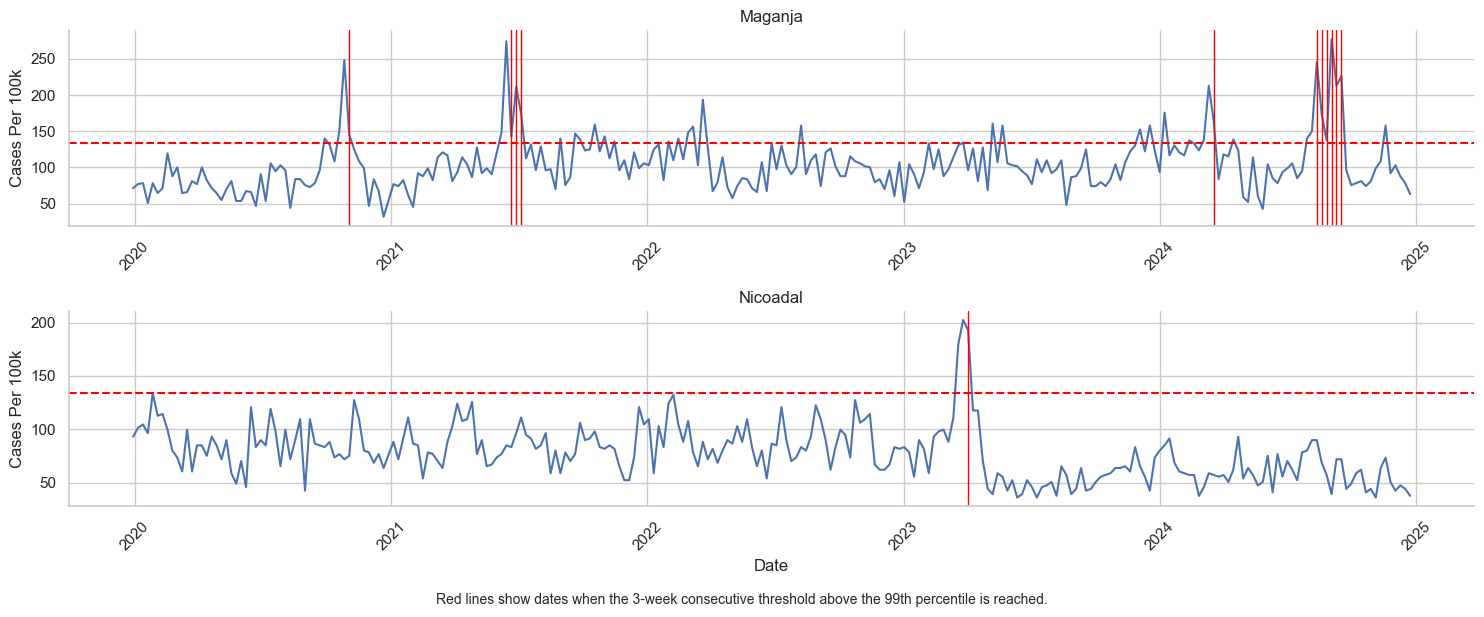

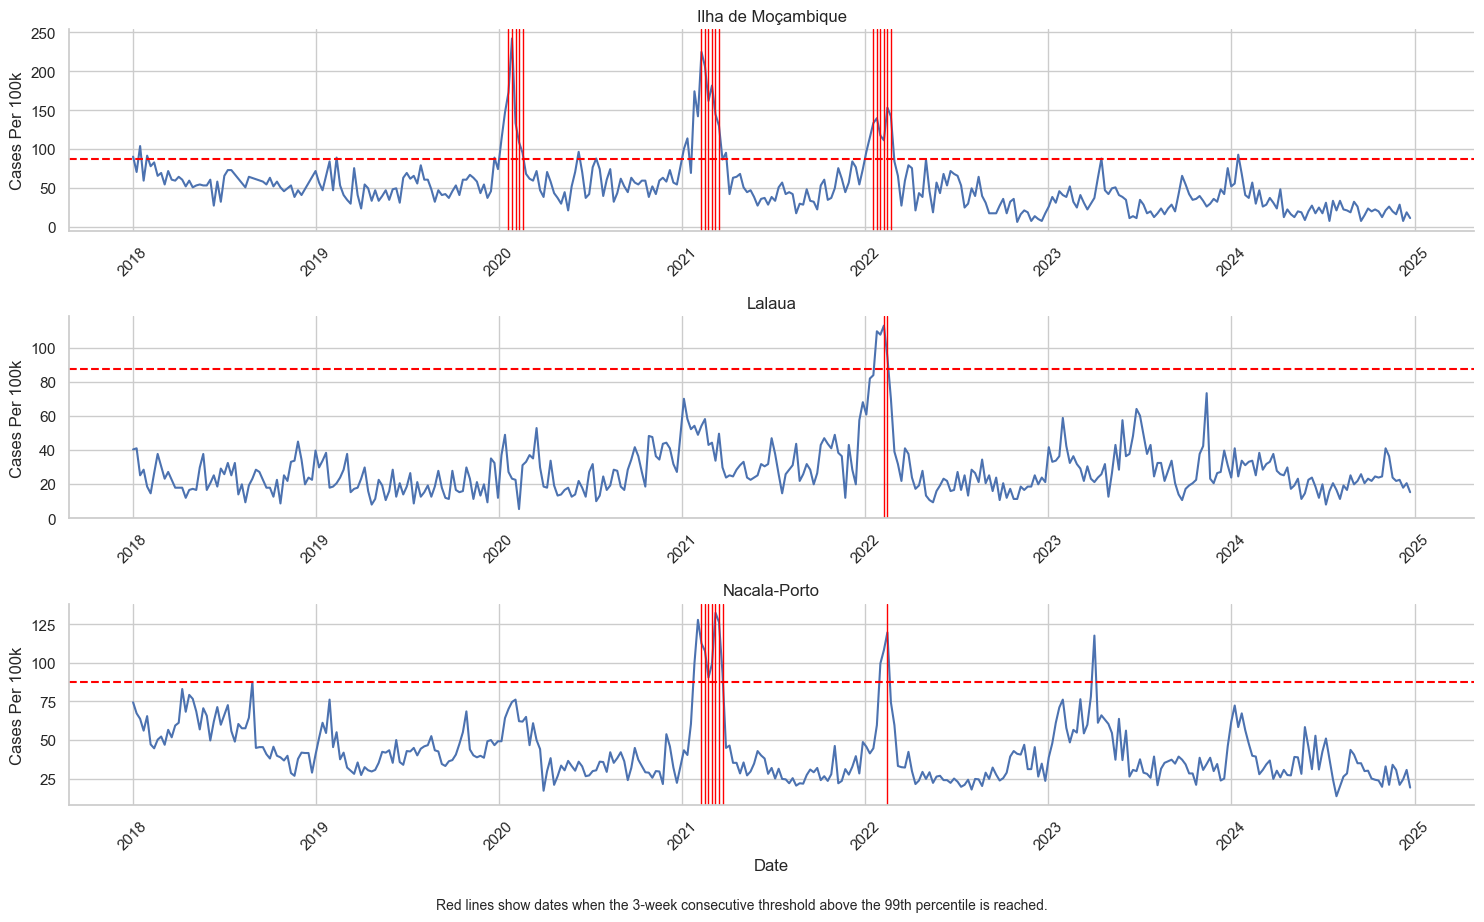

In [ ]:
unique_provinces = district_df_with_percentiles["province"].unique()

for province in unique_provinces:
    subset = district_df_with_percentiles[
        (district_df_with_percentiles["province"] == province)
        & (
            district_df_with_percentiles["district"].isin(
                district_trigger_99th["district"].unique()
            )
        )
    ]

    if subset.empty:
        continue

    g = sns.FacetGrid(
        subset,
        col="district",
        col_wrap=1,
        sharex=False,
        sharey=False,
        height=3,
        aspect=5,
    )

    # Plot main line
    g.map_dataframe(sns.lineplot, x="date", y="cases_per_100k")

    # Add horizontal 99th percentile line
    g.map_dataframe(
        lambda data, color, **kws: plt.axhline(
            y=data["p99"].iloc[0], color="red", linestyle="--"
        )
    )

    # Add vertical red lines where condition is true
    def add_vertical_lines(data, **kwargs):
        for date in data.loc[data["three_consec_above_99th"], "date"]:
            plt.axvline(x=date, color="red", linestyle="-", linewidth=1)

    g.map_dataframe(add_vertical_lines)

    g.set_titles(f"{{col_name}}")
    g.set_axis_labels("Date", "Cases Per 100k")

    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)

    plt.tight_layout()
    plt.figtext(
        0.5,
        -0.02,
        "Red lines show dates when the 3-week consecutive threshold above the 99th percentile is reached.",
        wrap=True,
        horizontalalignment="center",
        fontsize=10,
    )
    plt.show()